## CI/CD Pipeline Optimization with GitHub Actions Logs
Here’s the full content, organized into cells with markdown headers and Python code:


### 1. Setup & Configuration

In [27]:
# Install required packages (uncomment if needed)
# !pip install requests pandas seaborn scikit-learn scikit-optimize pyyaml matplotlib

import requests, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
from datetime import datetime
import yaml
import os
from dotenv import load_dotenv

# Load environment variables from .env file in project root
load_dotenv(dotenv_path=r'c:\Users\behip\Documents\Work\IT\30-Days-of-AI-in-Devops-SRE-Challenge-\.env')

# Load repo from config.yaml, token from env
with open("config.yaml") as f:
    config = yaml.safe_load(f)

REPO = config["repo"]
TOKEN = os.getenv("GITHUB_TOKEN")
if not TOKEN:
    raise ValueError("GitHub token not set. Please set the GITHUB_TOKEN environment variable in your .env file.")
HEADERS = {"Authorization": f"Bearer {TOKEN}"}

### 2. Fetch & Parse GitHub Actions Logs

In [22]:
def fetch_workflow_runs(repo, headers):
    url = f"https://api.github.com/repos/{repo}/actions/runs"
    runs = requests.get(url, headers=headers).json()["workflow_runs"]
    data = []
    for run in runs:
        start = datetime.fromisoformat(run["created_at"][:-1])
        end = datetime.fromisoformat(run["updated_at"][:-1])
        data.append({
            "id": run["id"],
            "name": run["name"],
            "status": run["status"],
            "conclusion": run["conclusion"],
            "duration": (end - start).total_seconds()
        })
    return pd.DataFrame(data)

df = fetch_workflow_runs(REPO, HEADERS)
df.to_csv("pipeline_logs.csv", index=False)
df.head()

,id,name,status,conclusion,duration
0,15127103693,CI,completed,success,56.0
1,15125796970,CI,completed,failure,49.0
2,15090945764,CI,completed,success,59.0
3,15090861449,CI,completed,failure,56.0
4,15090373686,CI,completed,failure,53.0


### 3. Visualize Build Time & Failure Rates

Failure Rate: 72.73%


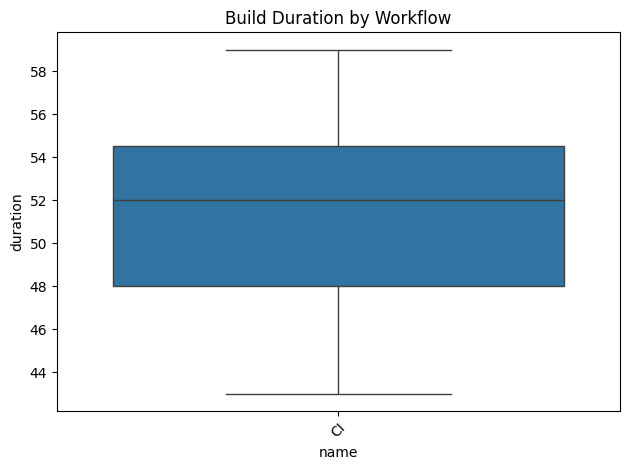

In [23]:
# Load logs
df = pd.read_csv("pipeline_logs.csv")

# Failure rate
failure_rate = df["conclusion"].value_counts(normalize=True).get("failure", 0)
print(f"Failure Rate: {failure_rate:.2%}")

# Duration boxplot
sns.boxplot(x="name", y="duration", data=df)
plt.xticks(rotation=45)
plt.title("Build Duration by Workflow")
plt.tight_layout()
plt.show()

### 4. Regression & Bayesian Optimization

In [24]:
from sklearn.ensemble import RandomForestRegressor
from skopt import gp_minimize
from skopt.space import Integer
import pandas as pd

# Simulate config features (replace with real metadata if available)
df["parallel_jobs"] = pd.Series([2, 4, 6, 8] * (len(df) // 4 + 1))[:len(df)]
df["cache_hit"] = pd.Series([0, 1] * (len(df) // 2 + 1))[:len(df)]

X = df[["parallel_jobs", "cache_hit"]]
y = df["duration"]

# Train regression model
model = RandomForestRegressor()
model.fit(X, y)

# Feature importances
importances = dict(zip(X.columns, model.feature_importances_))
print("\n📊 Feature Importances:")
for feature, score in importances.items():
    print(f"  - {feature}: {score * 100:.2f}% impact on build duration")

# Bayesian Optimization
def objective(params):
    parallel, cache = params
    input_df = pd.DataFrame([[parallel, cache]], columns=["parallel_jobs", "cache_hit"])
    pred = model.predict(input_df)
    return pred[0]

res = gp_minimize(objective, [Integer(1, 10), Integer(0, 1)], n_calls=20)

# Best configuration
best_config = dict(zip(X.columns, res.x))
print("\n✅ Best Configuration Found:")
for feature, value in best_config.items():
    if "cache" in feature.lower():
        print(f"  - {feature}: {'Enabled' if value == 1 else 'Disabled'}")
    else:
        print(f"  - {feature}: {value}")


📊 Feature Importances:
  - parallel_jobs: 74.22% impact on build duration
  - cache_hit: 25.78% impact on build duration


c:\Users\behip\Documents\Work\IT\30-Days-of-AI-in-Devops-SRE-Challenge-\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(3), np.int64(0)] before, using random point [np.int64(8), np.int64(1)]
  warnings.warn(
c:\Users\behip\Documents\Work\IT\30-Days-of-AI-in-Devops-SRE-Challenge-\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(3), np.int64(0)] before, using random point [np.int64(3), np.int64(1)]
  warnings.warn(



✅ Best Configuration Found:
  - parallel_jobs: 6
  - cache_hit: Disabled


### 5. Generate Recommendations


In [ ]:
import requests
from IPython.display import Markdown, display
import json

# CI/CD summary values
summary = {
    "Average Duration": df["duration"].mean(),
    "Failure Rate": df["conclusion"].value_counts(normalize=True).get("failure", 0),
    "Recommended Parallel Jobs": int(res.x[0]),
    "Recommended Cache Strategy": "Enabled" if res.x[1] == 1 else "Disabled"
}

# Format values
avg_duration_str = f"{summary['Average Duration']:.2f} minutes"
failure_rate_str = f"{summary['Failure Rate']*100:.2f}%"
parallel_jobs_str = str(summary["Recommended Parallel Jobs"])
cache_strategy_str = summary["Recommended Cache Strategy"]

# Construct prompt for LLM
prompt = f"""
You are a DevOps advisor. Based on the following CI/CD metrics, generate 3–5 key takeaways that are insightful, readable, and stakeholder-friendly.

Metrics:
- Average Build Duration: {avg_duration_str}
- Failure Rate: {failure_rate_str}
- Recommended Parallel Jobs: {parallel_jobs_str}
- Cache Strategy: {cache_strategy_str}

Focus on reliability, performance, and actionable improvements.
"""



response = requests.post(
    "http://localhost:11434/api/generate",
    json={"model": "llama2", "prompt": prompt},
    stream=True
)

# Collect streamed chunks
ai_text = ""
for line in response.iter_lines():
    if line:
        chunk = line.decode("utf-8")
        try:
            ai_text += json.loads(chunk)["response"]
        except Exception:
            pass  # skip malformed lines


# Build Markdown output
md_text = f"""
## 🚀 CI/CD Optimization Summary

| **Metric**                    | **Value**                |
|------------------------------|--------------------------|
| Average Build Duration       | `{avg_duration_str}`     |
| Failure Rate                 | `{failure_rate_str}`     |
| Recommended Parallel Jobs    | `{parallel_jobs_str}`    |
| Cache Strategy               | `{cache_strategy_str}`   |

---

### 🔍 Key Takeaways
{ai_text}
"""

# Render in notebook
display(Markdown(md_text))


## 🚀 CI/CD Optimization Summary

| **Metric**                    | **Value**                |
|------------------------------|--------------------------|
| Average Build Duration       | `51.18 minutes`     |
| Failure Rate                 | `72.73%`     |
| Recommended Parallel Jobs    | `6`    |
| Cache Strategy               | `Disabled`   |

---

### 🔍 Key Takeaways
As a DevOps advisor, here are 3–5 key takeaways based on the provided CI/CD metrics:

1. Slow Build Times Impact Deployment Reliability: With an average build duration of 51.18 minutes, it may be challenging to ensure consistent and reliable deployments. This could result in delayed deployments or missed deadlines, potentially affecting customer satisfaction and business operations. To improve deployment reliability, consider optimizing your build process or implementing a more efficient CI/CD pipeline.
2. High Failure Rate Indicates Deployment Quality Concerns: A failure rate of 72.73% highlights the need for improved quality assurance in your deployment process. This could lead to unstable deployments, and ultimately impact customer satisfaction and business operations. To address this issue, consider implementing additional testing or quality control measures throughout the CI/CD pipeline.
3. Underutilized Parallel Jobs Opportunity: With only 6 recommended parallel jobs being utilized, there is potential for improved performance and efficiency in your CI/CD pipeline. Enabling more parallel jobs could reduce build times and increase deployment frequency, resulting in faster time-to-market and improved customer satisfaction. To realize this benefit, consider increasing the number of parallel jobs or optimizing job scheduling to better utilize available resources.
4. Disabled Cache Strategy May Hinder Performance: Disabling cache strategy may cause your CI/CD pipeline to spend more time fetching dependencies, building, and deploying your application. This could result in slower deployment times and reduced performance. To address this issue, consider enabling a cache strategy or implementing other optimization techniques to reduce the time spent on these tasks.
5. Actionable Improvement Opportunities: Based on the provided metrics, there are several actionable improvement opportunities that can be addressed to enhance the reliability, performance, and overall effectiveness of your CI/CD pipeline. These include optimizing build times, improving quality assurance, utilizing parallel jobs more effectively, and enabling a cache strategy. By focusing on these areas, you can streamline your development processes and deliver high-quality applications to your customers faster and more efficiently.

In conclusion, by analyzing the provided CI/CD metrics, it is clear that there are several areas for improvement in your pipeline. Addressing these issues can help improve deployment reliability, reduce build times, and enhance overall performance. As a DevOps advisor, I recommend prioritizing these improvement opportunities to achieve better results from your CI/CD pipeline.
